In [21]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity
from qiskit.circuit.library.standard_gates import CRYGate
from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [2]:
unitary_param_1 = [3.6394377, 1.98700556, 4.48988233, 4.29453371, 0.99316018, 0.41805292,
                   2.50177143, 3.00526562, 3.68954483, 6.10950746, 5.17815346, 1.62734164,
                   4.37865732, 0.8921942,  6.12110679, 4.63305539]

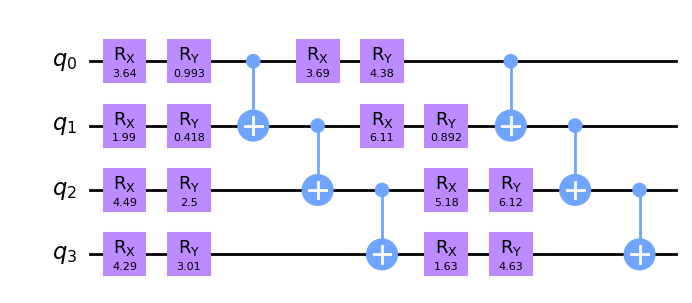

In [3]:
#State \rho_SR
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [26]:
I = np.array([[1, 0], [0, 1]])
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

In [27]:
S12 = np.kron(SWAP, I)
S23 = np.kron(I, SWAP)
S13 = np.array([[1,0,0,0,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,0,0,0,1,0], 
                [0,1,0,0,0,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,0,0,0,1]])
S12S23 = np.matmul(S12, S23)
S13S23 = np.matmul(S13, S23)

In [28]:
lis = []
lis.append(np.kron(np.kron(I, I), I)) #000
lis.append(S23) #001
lis.append(S13)
lis.append(S13S23)
lis.append(S12) #010
lis.append(S12S23)

In [104]:
def createWernerState(F):
    theta1 = 2*np.arccos(np.sqrt(0.667*(1-F)))
    theta2 = 2*np.arctan(np.sqrt(3*F/(1-F)))
    
    state = QuantumCircuit(4)
    state.ry(theta1, 2)
    state.append(CRYGate(theta2), [2, 3])
    state.x(2)
    state.ch(2, 3)
    state.x(2)
    
    state.h(0)
    state.cx(0, 1)
    
    state.cz(0, 3)
    state.cx(2, 0)
    
    return state

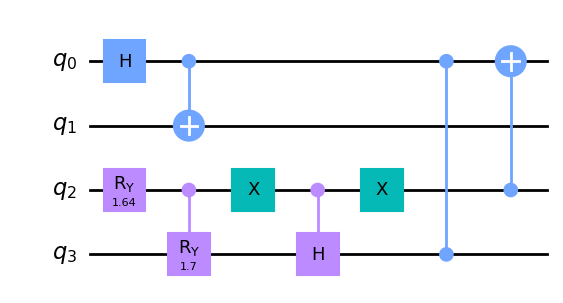

In [105]:
createWernerState(0.3).draw('mpl')

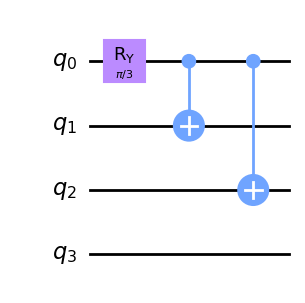

In [106]:
qcTest = QuantumCircuit(4)
qcTest.ry(np.pi/3, 0)
qcTest.cx(0, 1)
qcTest.cx(0, 2)
qcTest.draw('mpl')

In [116]:
psi = np.array(DensityMatrix.from_instruction(createWernerState(0.90).reverse_bits()))
rho = pt(psi, [3, 4], [2, 2, 2, 2]) #rho_S
print(rho)

[[ 0.03335   +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.46665   +0.j -0.43331786+0.j  0.        +0.j]
 [ 0.        +0.j -0.43331786+0.j  0.46665   +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.03335   +0.j]]


In [117]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(np.kron(I, S12).shape, complex=True)
G = cp.bmat([[rho, X.H],[X, pt(omega, [3, 4], [2, 2, 2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

for item in lis:
    c.append(omega@np.kron(I, item) == np.kron(I, item)@omega)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 272 empty
WARN: A->p (column pointers) not strictly increasing, column 391 empty
WARN: A->p (column pointers) not strictly increasing, column 408 empty
WARN: A->p (column pointers) not strictly increasing, column 527 empty
Root Fidelity is : 0.9571878844285074


In [118]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.9162086460967217
